# Train the network using the REDISAI db as an exchange place and debug the problems


In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.models as models
import torch.utils.data as tdata

import numpy as np
import redisai as rai

from dataclasses import dataclass
import pickle

import matplotlib.pyplot as plt
import pymongo

# Ip of minikube and the port of the mongo service
MONGO_IP = '192.168.99.101'
MONGO_PORT = 30933

# import the modules used in the program
import train_utils
import ml2rt

## Create the network

In [2]:
@dataclass
class TrainParams:
    ps_id: str
    N: int
    task: str
    func_id: int
    lr: float
    batch_size: int
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
def create_model(init: bool):
    """Creates the model used to train the network

    For this example we'll be using the simple model from the MNIST examples
    (https://github.com/pytorch/examples/blob/master/mnist/main.py)
    """

    def init_weights(m: nn.Module):
        """Initialize the weights of the network"""
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.01)
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.01)

    # Create the model and initialize the weights
    model = Net()

    # If the task is initializing the layers do so
    if init:
        print('Initializing layers...')
        model.apply(init_weights)

    return model

In [44]:
torch.cuda.is_available()

True

## Create the Dataloader

In [45]:

# TODO max document size is 16 MB, this could give us problems in the future
# when the datasets are so big, we should calculate the size (easy, and divide the dataset)
def split_dataset(X, Y, subsets):
    """Splits the X and Y in N different subsets"""
    X_split = np.split(X, subsets)
    Y_split = np.split(Y, subsets)
    
    return X_split, Y_split


def approx_size(a: np.array):
    """ approx size of float 32 array in MB"""
    return (32/8) * np.prod(a.shape) / 1e6



In [15]:
47*128, 16*128

(6016, 2048)

In [7]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_data = datasets.MNIST('./data', train=True, download=False, transform=transform)
val_data = datasets.MNIST('./data', train=False, download=False, transform=transform)

train_data.data, train_data.targets = train_data.data[:3000], train_data.targets[:3000]
val_data.data, val_data.targets = val_data.data[:2000], val_data.targets[:2000]

In [8]:

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128)
len(train_loader), len(val_loader)

(24, 16)

# Define the train and test methods


In [140]:
def train(model: nn.Module, device,
          train_loader: tdata.DataLoader,
          optimizer: torch.optim.Optimizer, tensor_dict) -> float:
    """Loop used to train the network"""
    model.train()
    loss, tot = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        print(data.shape, target.shape)
        optimizer.zero_grad()
        output = model(data)
        print(output.shape)

        loss = F.nll_loss(output, target)
        tot += loss.item()
        loss.backward()

        # Here save the gradients to publish on the database
#         train_utils.update_tensor_dict(model, tensor_dict)
        optimizer.step()
        

        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                1, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), loss.item()))

    return tot/len(train_loader)


def validate(model, device, val_loader: tdata.DataLoader) -> (float, float):
    """Loop used to validate the network"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(val_loader.dataset)

    accuracy = 100. * correct / len(val_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return accuracy, test_loss

def infer(model, device, data: np.array):
    """Forward the data through the network and return the predictions"""
    model.eval()
    data = transform(data).to(device)
    data = data.permute(1, 2, 0).view(-1, 1, 28, 28)
    out = model(data)
    
    preds = torch.argmax(out, axis=1)
    return preds.cpu().numpy()
    
    

In [103]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)

## Main entrypoint of the code

In [23]:
from copy import deepcopy

params = TrainParams(ps_id='example', func_id=0, N =2, task='train', lr=0.01, batch_size=128)


torch.manual_seed(42) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

# Create the model
model = create_model(init=True).to(device)

Initializing layers...


In [50]:
# Create the redis connection
addr = '192.168.99.101'
port = 31618
con = rai.Client(debug=True, host=addr, port=port)

### Train for a couple of epochs

In [77]:
%%time
# create the tensor dict
tdict = dict()

optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1,3):
    print('Epoch', epoch)
    train(model, device, train_loader, optimizer, tdict)
    validate(model, device, val_loader)


Epoch 1
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
Train Epoch: 1 [0/3000 (0%)]	Loss: 0.441164
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
Train Epoch: 1 [640/3000 (21%)]	Loss: 0.476388
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
Train Epoch: 1 [1280/3000 (42%)]	Loss: 0.634671
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
torch.Size([128, 1, 28, 2

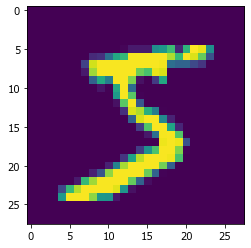

In [130]:
plt.imshow(train_data.data[0].numpy().squeeze())

torch.Size([6, 28, 28])
torch.Size([6, 1, 28, 28])
torch.Size([6, 1, 28, 28])


tensor([5, 0, 4, 1, 4, 2], device='cuda:0')

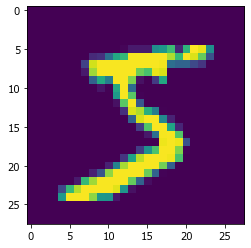

In [133]:
input_test = np.random.rand(28, 28, 2).astype('float32')
data = train_data.data[:6].numpy()
t = transform(data).to(device)
t = t.permute(1, 2, 0)
print(t.shape)
t = t.view(-1, 1, 28, 28)
print(t.shape)

plt.imshow(t[0].cpu().numpy().squeeze())
print(t.shape)
# t = torch.Tensor(input_test).to(device)
# out = model(t)
out=model.forward(t)

a = np.array([4], dtype='int64')
target = torch.as_tensor(a).to(device)
pred = torch.argmax(out, axis=1)
pred

In [176]:
t = train_data.data[:10].numpy()
infer(model, device, t)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
p = pickle.dumps(model.state_dict())


In [159]:
model.cpu().state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0710,  0.1848,  0.0198],
                        [-0.2222, -0.1628, -0.2172],
                        [-0.0973, -0.0572, -0.1459]]],
              
              
                      [[[-0.1846, -0.0205, -0.0799],
                        [-0.0126,  0.0830, -0.2512],
                        [-0.0528, -0.1518, -0.0973]]],
              
              
                      [[[-0.1700,  0.0730,  0.1478],
                        [-0.2474,  0.1059,  0.2154],
                        [-0.0067, -0.2537, -0.1290]]],
              
              
                      [[[ 0.0379, -0.0428, -0.1682],
                        [-0.0059,  0.0958, -0.0359],
                        [ 0.0487, -0.0123,  0.0376]]],
              
              
                      [[[-0.1336,  0.0980,  0.1453],
                        [ 0.0606,  0.1253,  0.0542],
                        [-0.0262,  0.0133,  0.1075]]],
              
              
               

In [223]:
model = model.to(device)

## Save the model in the database

In [150]:
client = pymongo.MongoClient(MONGO_IP, MONGO_PORT)

In [216]:
db = client['kubeml']
db.drop_collection('network')

{'nIndexesWas': 1, 'ns': 'kubeml.network', 'ok': 1.0}

In [217]:
db['network'].insert_one(
    {
        "_id": "test",
        "state_dict": pickle.dumps(model.cpu().state_dict())
}).inserted_id

'test'

In [172]:
res = db['network'].find_one({"_id": "test"})
model.load_state_dict(pickle.loads(res['state']))

<All keys matched successfully>

# Invoke the function with some data

In [200]:
import requests
import json

ROUTER_ADDRESS = "http://192.168.99.101:32422"
FUNCTION = "network"

In [237]:
data = train_data.data[0].numpy().tolist()
# data = np.array(data, dtype='uint8')
# infer(model, device, data)

In [245]:
js = json.dumps({"data":data})
with open('example.json', 'w') as f:
    f.write(js)

In [246]:
# send the request 
# url = "http://192.168.99.101:32422/inference?N=1&batchSize=128&funcId=0&lr=0.01&psId=test&task=infer"
url = "http://192.168.99.101:32422/network?N=1&batchSize=0&funcId=0&lr=1&psId=test&task=infer"


In [247]:
res = requests.post(url, json={"data": data })

In [205]:
res = requests.get(url)

In [248]:
res.json()['predictions']

[5]